In [2]:
pip install sentence_transformers

  Obtaining dependency information for sentence_transformers from https://files.pythonhosted.org/packages/8b/c8/990e22a465e4771338da434d799578865d6d7ef1fdb50bd844b7ecdcfa19/sentence_transformers-3.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for transformers<5.0.0,>=4.41.0 from https://files.pythonhosted.org/packages/51/51/b87caa939fedf307496e4dbf412f4b909af3d9ca8b189fc3b65c1faa456f/transformers-4.46.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.1 MB/s eta 0:00:00
  Obtaining dependency information for torch>=1.11.0 from https://files.pythonhosted.org/packages/d0/db/5d9cbfbc7968d79c5c09a0bc0bc3735da079f2fd07cc10498a62b320a480/torch-2.5.1-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for huggingface-hub>=0.20.0 from https://files.pythonhosted.org/packages/95/9b/3068fb3ae0b498eb66960ca5f4d92a81c91458cacd4dc17bfa6d40ce90fb/huggingface_hub-0.26.3-py3-none-any.whl.metadata
  Obtaining dependency in

In [3]:
import pandas as pd
import re
from langdetect import detect
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer, util
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

file_path = '/Users/williamsempire/Desktop/Columbia/Courses/5067 NLP/FinalProj/chatgpt_reviews_daily_updated.csv'
data = pd.read_csv(file_path)
data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,764bde06-e9d2-4211-97a2-f4f64bcf907d,M A saad,very active,5,0,1.2024.310,2024-11-18 13:31:58,1.2024.310
1,36788635-5d48-4a4e-abdd-7fadffc07ac1,Sudip Sarkar,very nice app 🥰,5,0,1.2024.268,2024-11-18 13:31:31,1.2024.268
2,74a2c5ec-2bdb-4784-ab8a-90224d65d981,Sehlule Moyo,good app,4,0,1.2024.268,2024-11-18 13:31:05,1.2024.268
3,0f7a206b-4a5c-4b67-ad59-54e4d3cefe01,Preethi Preru,very good,5,0,1.2024.310,2024-11-18 13:29:14,1.2024.310
4,e8f1438a-3734-4213-9884-aa33a9b79672,Fayzan Vhora,this is nice app for student,3,0,1.2024.310,2024-11-18 13:27:53,1.2024.310


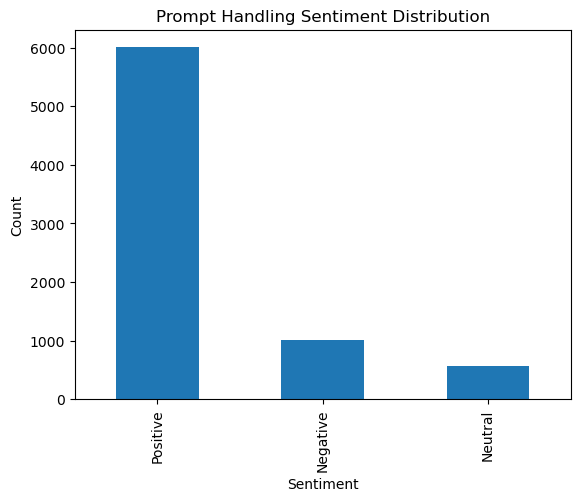

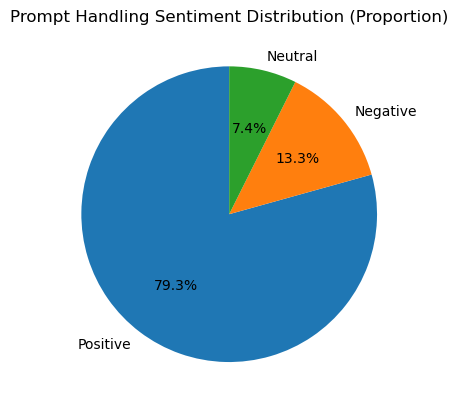

In [20]:
# 1. Basic information of Prompt handling (Does the system produce results that meet user expectations?)
prompt_related = data[data['prompt_handling'] == True]
prompt_sentiment = prompt_related['content_Sentiment'].value_counts()
prompt_sentiment.plot(kind='bar', title="Prompt Handling Sentiment Distribution", ylabel="Count", xlabel="Sentiment")
plt.show()

prompt_sentiment_ratio = prompt_sentiment / prompt_sentiment.sum()
prompt_sentiment_ratio.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    title="Prompt Handling Sentiment Distribution (Proportion)"
)
plt.ylabel('')
plt.show()


score distribution：
sentiment_label  Negative   Neutral  Positive
score                                        
1                0.545198  0.172316  0.282486
2                0.464883  0.120401  0.414716
3                0.300537  0.121646  0.577818
4                0.141471  0.092158  0.766370
5                0.032698  0.064137  0.903165

performance distribution：
sentiment_label
Positive    0.756757
Negative    0.164865
Neutral     0.078378
Name: proportion, dtype: float64

user_interface distribution：
sentiment_label
Positive    0.865629
Negative    0.094767
Neutral     0.039604
Name: proportion, dtype: float64

response_quality distribution：
sentiment_label
Positive    0.787171
Negative    0.129516
Neutral     0.083313
Name: proportion, dtype: float64


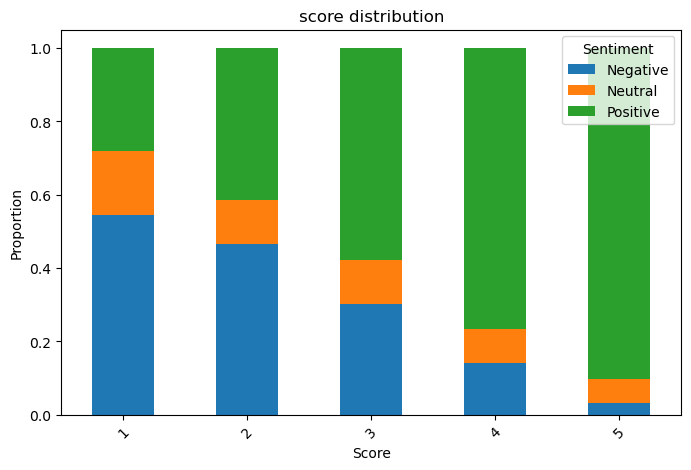

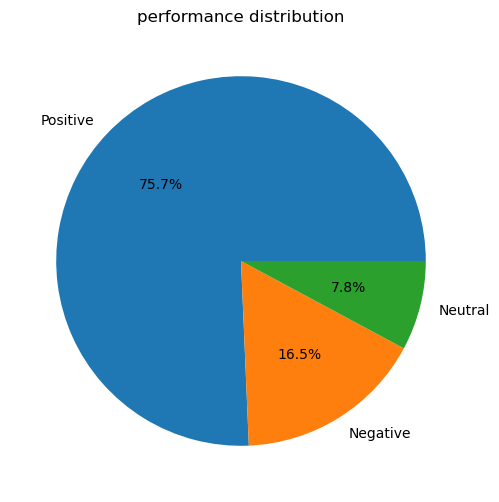

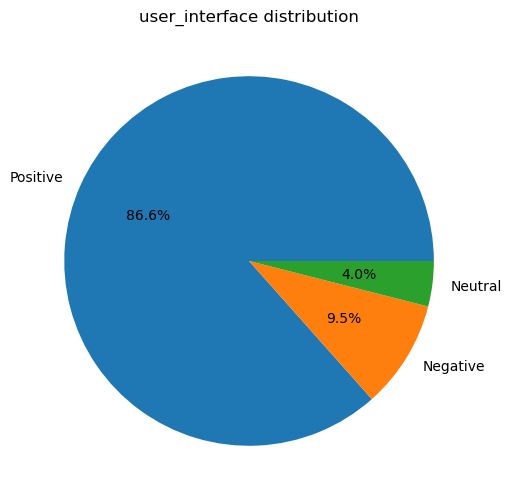

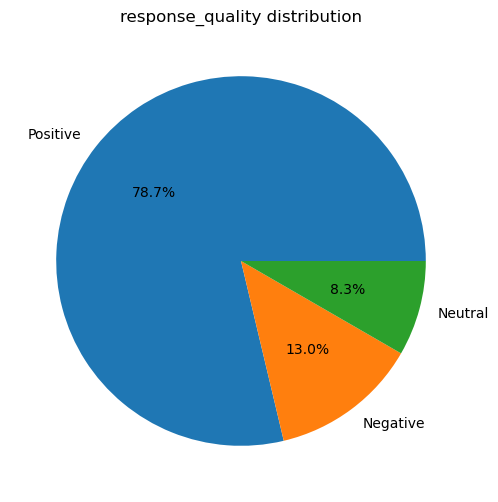

In [23]:
analyzer = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
data['sentiment_label'] = data['sentiment_score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
negative_comments = data[data['sentiment_label'] == 'Negative']['content'].tolist()

prompt_data = data[data['prompt_handling'] == True]
columns_to_analyze = ['score', 'performance', 'user_interface', 'response_quality']
feedback_distribution = {}

for column in columns_to_analyze:
    if column == 'score':
        feedback_distribution[column] = prompt_data.groupby([column])['sentiment_label'].value_counts(normalize=True).unstack()
    else:
        feedback_distribution[column] = prompt_data[prompt_data[column] == True]['sentiment_label'].value_counts(normalize=True)

for column, distribution in feedback_distribution.items():
    print(f"\n{column} distribution：")
    print(distribution)

for column, distribution in feedback_distribution.items():
    if column == 'score':
        distribution.plot(kind='bar', stacked=True, title=f'{column} distribution', ylabel='Proportion', xlabel='Score', figsize=(8, 5))
        plt.legend(title='Sentiment')
        plt.xticks(rotation=45)
    else:
        distribution.plot(kind='pie', autopct='%1.1f%%', title=f'{column} distribution', ylabel='', figsize=(6, 6))
    plt.show()

In [42]:
# 2. What difficulties were encountered in the process
negative_comments = prompt_related[prompt_related['content_Sentiment'] == 'Negative']
negative_tokens = negative_comments['tokens'].dropna().apply(eval)
negative_token_list = list(chain.from_iterable(negative_tokens))
negative_token_counts = Counter(negative_token_list).most_common(10)
print("High frequency keywords for negative reviews：", negative_token_counts)

negative_comments_text = negative_comments['tokens'].dropna().apply(eval).apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(negative_comments_text)
bigrams = vectorizer.get_feature_names_out()
bigram_counts = Counter(dict(zip(bigrams, X.toarray().sum(axis=0)))).most_common(20)
print("High frequency double phrases for negative comments：", bigram_counts)

High frequency keywords for negative reviews： [('question', 868), ('answer', 534), ("n't", 490), ('app', 479), ("'s", 294), ('give', 221), ('ask', 213), ('time', 184), ('even', 168), ('wrong', 162)]
High frequency double phrases for negative comments： [('answer question', 133), ('ask question', 105), ('wrong answer', 55), ('question answer', 47), ('chat gpt', 46), ('asked question', 39), ('asking question', 33), ('simple question', 31), ('question asked', 22), ('try later', 22), ('answering question', 21), ('answer wrong', 20), ('correct answer', 19), ('ca answer', 18), ('type question', 18), ('question ask', 17), ('paid version', 15), ('question say', 15), ('edit prompt', 14), ('chatgpt app', 13)]


In [43]:
time_negative_comments = negative_comments[negative_comments['content'].str.contains('time', case=False, na=False)]
pd.set_option('display.max_colwidth', None)
print("Examples of negative comments containing 'time'：")
print(time_negative_comments['content'].head(5))

Examples of negative comments containing 'time'：
502                                                                                                                                                                                                                         it's not working for the past few days every time i am trying to use it or asking a question it's just not working showing "something has gone wrong" means unable to show me result
6431                                                                           as a user experience designer the experience of the previous is better than this appearance of cloud and the change of voice previous voice is far far better response time of this is very bad infact is slow and it is asking strange question not in response to the old app i might uninstall after a while for other options
7016                                                                                                                                                 

In [44]:
time2_negative_comments = negative_comments[negative_comments['content'].str.contains('slow', case=False, na=False)]
pd.set_option('display.max_colwidth', None)
print("Examples of negative comments containing the word 'slow' :")
print(time2_negative_comments['content'].head(5))

Examples of negative comments containing the word 'slow' :
6431                                                                                                                                                                                as a user experience designer the experience of the previous is better than this appearance of cloud and the change of voice previous voice is far far better response time of this is very bad infact is slow and it is asking strange question not in response to the old app i might uninstall after a while for other options
10203                                                                                                         great app when it works i lost my threads it's still there but i can't continue prompting on it then it's losing all the record and memories you start to write something you switch app come back to the app everything you've written disappears the app is slow crashing all the time whether it's the desktop app desktop website or 

In [45]:
wrong_negative_comments = negative_comments[negative_comments['content'].str.contains('wrong', case=False, na=False)]
pd.set_option('display.max_colwidth', None)
print("Examples of negative comments containing 'wrong'：")
print(wrong_negative_comments['content'].head(5))

Examples of negative comments containing 'wrong'：
502                                                                                                                                                                                                                                                                                                                            it's not working for the past few days every time i am trying to use it or asking a question it's just not working showing "something has gone wrong" means unable to show me result
2479                                                                                                                                                                                                                                                                                                          i just downloaded the app and i only get to interact with just 4 questionsthen i'm getting a notification to wait for the next 5hrs to make use of i

In [46]:
texts = wrong_negative_comments['content'].tolist()
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(texts)
# KMeans
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)
wrong_negative_comments['cluster'] = kmeans.labels_
score = silhouette_score(X, kmeans.labels_)
print(f"The Silhouette score of the cluster: {score}")

for cluster in range(num_clusters):
    print(f"Sample comments for cluster {cluster}:")
    cluster_comments = wrong_negative_comments[wrong_negative_comments['cluster'] == cluster]['content']
    print(cluster_comments.head(1))
    print("-" * 50)


E:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The Silhouette score of the cluster: 0.015226829854633226
Sample comments for cluster 0:
11106    i asked the same question of the writer of a novel more than 10 times cause it couldn't answer properly but it answered 10 different authors something is really wrong can't be trusted
Name: content, dtype: object
--------------------------------------------------
Sample comments for cluster 1:
2479    i just downloaded the app and i only get to interact with just 4 questionsthen i'm getting a notification to wait for the next 5hrs to make use of it or i purchase the chat gpt plusso what is wrong
Name: content, dtype: object
--------------------------------------------------
Sample comments for cluster 2:
502    it's not working for the past few days every time i am trying to use it or asking a question it's just not working showing "something has gone wrong" means unable to show me result
Name: content, dtype: object
--------------------------------------------------
Sample comments for cl

C:\Users\Lixiaoyang\AppData\Local\Temp\ipykernel_25012\2359154977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_negative_comments['cluster'] = kmeans.labels_


In [47]:
model = SentenceTransformer('all-MiniLM-L6-v2')
example_issue = "The answers to the same question are inconsistent."
embeddings = model.encode(texts, convert_to_tensor=True)
example_embedding = model.encode(example_issue, convert_to_tensor=True)
cosine_scores = util.pytorch_cos_sim(example_embedding, embeddings).squeeze()
top_matches = cosine_scores.topk(k=5)
print("The comment most similar to the sample question:")
for idx in top_matches.indices:
    print(texts[idx])

The comment most similar to the sample question:
i received multiple wrong answers from one question
answers of several questions are absolutely wrong
wrong answer of my question 3 times
somethimes it's responses are poor and answers are wrong and also it can't explain a single thing instead it repeats one answer over and over again when a question is asked multiple times
some of the question it answered wrong 


In [49]:
nltk.download('stopwords')
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text
    
# Filtering and prompt_handling and user_interface are both True
interface_prompt_data = data[(data['prompt_handling'] == True) & (data['user_interface'] == True)]
negative_interface_prompt = interface_prompt_data[interface_prompt_data['content_Sentiment'] == 'Negative']
negative_interface_prompt['cleaned_content'] = negative_interface_prompt['content'].apply(clean_text)
stop_words = set(stopwords.words('english'))
tokens = negative_interface_prompt['cleaned_content'].dropna().apply(lambda x: [word for word in x.split() if word not in stop_words])

token_list = list(chain.from_iterable(tokens))

token_counts = Counter(token_list).most_common(20)

print("High frequency keywords:")
print(token_counts)

vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20, stop_words='english')
ngram_matrix = vectorizer.fit_transform(negative_interface_prompt['cleaned_content'].dropna())
ngram_features = vectorizer.get_feature_names_out()

print("\nHigh frequency bigrams:")
print(ngram_features)


High frequency keywords:
[('app', 31), ('question', 22), ('questions', 19), ('answer', 19), ('chatgpt', 17), ('ai', 17), ('even', 16), ('answers', 13), ('asked', 13), ('ask', 12), ('input', 12), ('use', 11), ('good', 11), ('doesnt', 11), ('prompt', 11), ('one', 9), ('issue', 9), ('chat', 9), ('quite', 9), ('responses', 9)]

High frequency bigrams:
['amazing app' 'answer questions' 'app does' 'app doesnt' 'app quite'
 'asked question' 'chat gpt' 'chatgpt app' 'chatgpt save' 'dinner scene'
 'false information' 'input field' 'instead answering' 'mandarin written'
 'paid version' 'recent conversations' 'text input' 'view recent'
 'wont answer' 'written sentences']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lixiaoyang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Lixiaoyang\AppData\Local\Temp\ipykernel_25012\2773973989.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_interface_prompt['cleaned_content'] = negative_interface_prompt['content'].apply(clean_text)


In [48]:
interface_prompt_data = data[(data['prompt_handling'] == True) & (data['response_quality'] == True)]
negative_interface_prompt = interface_prompt_data[interface_prompt_data['content_Sentiment'] == 'Negative']
negative_interface_prompt['cleaned_content'] = negative_interface_prompt['content'].apply(clean_text)
stop_words = set(stopwords.words('english'))
tokens = negative_interface_prompt['cleaned_content'].dropna().apply(lambda x: [word for word in x.split() if word not in stop_words])

token_list = list(chain.from_iterable(tokens))
token_counts = Counter(token_list).most_common(20)

print("High frequency keywords:")
print(token_counts)

vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20, stop_words='english')
ngram_matrix = vectorizer.fit_transform(negative_interface_prompt['cleaned_content'].dropna())
ngram_features = vectorizer.get_feature_names_out()

print("\nHigh frequency bigrams:")
print(ngram_features)


High frequency keywords:
[('answer', 367), ('question', 279), ('app', 262), ('questions', 247), ('answers', 168), ('wrong', 122), ('give', 117), ('ask', 113), ('chatgpt', 91), ('asked', 82), ('ai', 81), ('even', 80), ('cant', 77), ('dont', 73), ('like', 72), ('doesnt', 72), ('good', 67), ('time', 64), ('response', 61), ('gives', 60)]

High frequency bigrams:
['answer question' 'answer questions' 'answer wrong' 'answering questions'
 'answers questions' 'ask question' 'asked question' 'chat gpt'
 'correct answer' 'doesnt answer' 'gives wrong' 'good app'
 'question answer' 'question asked' 'right answer' 'simple question'
 'waste time' 'worst app' 'wrong answer' 'wrong answers']


C:\Users\Lixiaoyang\AppData\Local\Temp\ipykernel_25012\302005919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_interface_prompt['cleaned_content'] = negative_interface_prompt['content'].apply(clean_text)


In [50]:
interface_prompt_data = data[(data['prompt_handling'] == True) & (data['performance'] == True)]
negative_interface_prompt = interface_prompt_data[interface_prompt_data['content_Sentiment'] == 'Negative']
negative_interface_prompt['cleaned_content'] = negative_interface_prompt['content'].apply(clean_text)
stop_words = set(stopwords.words('english'))
tokens = negative_interface_prompt['cleaned_content'].dropna().apply(lambda x: [word for word in x.split() if word not in stop_words])

token_list = list(chain.from_iterable(tokens))
token_counts = Counter(token_list).most_common(20)

print("High frequency keywords:")
print(token_counts)

vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20, stop_words='english')
ngram_matrix = vectorizer.fit_transform(negative_interface_prompt['cleaned_content'].dropna())
ngram_features = vectorizer.get_feature_names_out()

print("\nHigh frequency bigrams：")
print(ngram_features)


High frequency keywords:
[('app', 46), ('question', 24), ('slow', 20), ('answer', 18), ('questions', 17), ('like', 14), ('prompt', 14), ('doesnt', 11), ('ai', 11), ('prompts', 11), ('use', 11), ('version', 11), ('even', 10), ('chatgpt', 9), ('wrong', 9), ('cant', 9), ('responses', 9), ('time', 8), ('dont', 8), ('giving', 7)]

High frequency bigrams：
['answer hindi' 'answer questions' 'deta hai' 'dinner scene' 'doesnt work'
 'fast answer' 'fastboot mode' 'faster running' 'important note'
 'keeps crashing' 'kind slow' 'koi bhi' 'lagging times' 'message wrong'
 'paid version' 'running mile' 'simple question' 'way better'
 'web version' 'wrong answer']


C:\Users\Lixiaoyang\AppData\Local\Temp\ipykernel_25012\2625154696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_interface_prompt['cleaned_content'] = negative_interface_prompt['content'].apply(clean_text)


In [51]:
analyzer = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
data['sentiment_label'] = data['sentiment_score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
negative_comments = data[data['sentiment_label'] == 'Negative']['content'].tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')

example_issue = "Prompt writing is hard to understand or use."

embeddings = model.encode(negative_comments, convert_to_tensor=True)
example_embedding = model.encode(example_issue, convert_to_tensor=True)

cosine_scores = util.pytorch_cos_sim(example_embedding, embeddings)

top_matches = cosine_scores.topk(k=20)
print("The most relevant negative comments related to prompt writing:")

for idx in top_matches.indices.squeeze().tolist():
    print(negative_comments[idx])

The most relevant negative comments related to prompt writing:
misunderstood prompts
worst thing i have ever used really inaccurate it cannot even understand simple prompt
👍 for everything it takes prompt and generate that prompt as it written's but 1/100 times it mistakes in some
poor understanding of prompts and low quality responses
basically read-only odd decision to not let you edit prompts
no complaints though i wish you were able to edit your prompts
could be wonderfully useful but alas it puts its own agenda far before the user and incorrigibly ignores prompts might be good for one hit wonders but its twisted love of infinite loops and pointless repetition make it useless for serious tasks if it reflects its creators they must be cruel and quiet unusual
the web version is much better here using backspace while writing a prompt removes space between the previous two words which is quite frustrating also there should be an edit option for previous prompts so that resubmission is 

In [52]:
# 3.
analyzer = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
data['sentiment_label'] = data['sentiment_score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

keywords = ['step-by-step', 'example', 'optimize', 'task decomposition', 'instruction', 'prompt engineering']
keyword_comments = data[data['content'].str.contains('|'.join(keywords), case=False, na=False)]

sentiment_distribution = keyword_comments['sentiment_label'].value_counts()
print("Sentiment distribution for comments related to prompt engineering:")
print(sentiment_distribution)

model = SentenceTransformer('all-MiniLM-L6-v2')

example_issue = "Does prompt optimization work or fail, like using step-by-step or examples?"
texts = keyword_comments['content'].tolist()

embeddings = model.encode(texts, convert_to_tensor=True)
example_embedding = model.encode(example_issue, convert_to_tensor=True)

cosine_scores = util.pytorch_cos_sim(example_embedding, embeddings)

top_matches = cosine_scores.topk(k=5)
print("\nMost relevant comments about prompt engineering issues:")

for idx in top_matches.indices.squeeze().tolist():
    print(texts[idx])

negative_comments = keyword_comments[keyword_comments['sentiment_label'] == 'Negative']
negative_texts = negative_comments['content'].tolist()

negative_embeddings = model.encode(negative_texts, convert_to_tensor=True)
cosine_scores_negative = util.pytorch_cos_sim(example_embedding, negative_embeddings)

negative_top_matches = cosine_scores_negative.topk(k=5)
print("\nMost relevant negative comments about prompt engineering:")
for idx in negative_top_matches.indices.squeeze().tolist():
    print(negative_texts[idx])

Sentiment distribution for comments related to prompt engineering:
sentiment_label
Positive    456
Negative    135
Neutral      42
Name: count, dtype: int64

Most relevant comments about prompt engineering issues:
so nice to have it always ready for a prompt also it supports the customization instructions  what a bonus
you have to look up prompt engineering to really use this to it's full time saving potential it's amazing
when given proper instructions it generates very satisfactory results
was so impressive at first but seems to be getting worse rapidly for anything other than generating walls of text it frequently lies doubles down on those lies answers simple yes or no questions with rambling soliloquies and will not consistently follow basic "conversation" instructions and parameters this leads to me spending most of my time and daily prompt chances correcting it or reminding it to follow instructions not worth a monthly fee anymore imo but still useful as a free tool
optimized

M